In [1]:
import pandas as pd

df = pd.read_csv('input/two_class_pap_acne.csv')
df['file_name']=df['image_id']+'.jpg'
df=df[['file_name','dx','lesion_id']]
#df.head()

from sklearn.model_selection import train_test_split
label_dataframe=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(df, label_dataframe, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.4, random_state=42)
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(17, 2)
(25, 2)
(5, 2)


In [2]:
train=pd.concat([X_train,y_train],axis=1)
train.head()
val=pd.concat([X_val,y_val],axis=1)
val.head()
test=pd.concat([X_test,y_test],axis=1)
test.head()

,file_name,lesion_id,dx
27,0 (136).jpg,55,acne
39,0 (166).jpg,67,acne
26,0 (135).jpg,55,acne
43,0 (175).jpg,71,papule
24,0 (127).jpg,52,acne


In [3]:
from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(val['dx'])
label=vle.transform(val['dx']) 
print(list(vle.classes_))
val['label']=label
print(train.head())
le_name_mapping = dict(zip(vle.classes_, vle.transform(vle.classes_)))
print(le_name_mapping)

trle = preprocessing.LabelEncoder()
trle.fit(train['dx'])
label=trle.transform(train['dx']) 
print(list(trle.classes_))
train['label']=label
print(train.head())
le_name_mapping = dict(zip(trle.classes_, trle.transform(trle.classes_)))
print(le_name_mapping)

le = preprocessing.LabelEncoder()
le.fit(test['dx'])
label=le.transform(test['dx']) 
print(list(le.classes_))
test['label']=label
print(test.head())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['acne', 'papule']
      file_name  lesion_id      dx
20   0 (94).jpg         39    acne
46  0 (178).jpg         71  papule
36  0 (163).jpg         66    acne
34  0 (153).jpg         62    acne
8    0 (46).jpg         22  papule
{'acne': 0, 'papule': 1}
['acne', 'papule']
      file_name  lesion_id      dx  label
20   0 (94).jpg         39    acne      0
46  0 (178).jpg         71  papule      1
36  0 (163).jpg         66    acne      0
34  0 (153).jpg         62    acne      0
8    0 (46).jpg         22  papule      1
{'acne': 0, 'papule': 1}
['acne', 'papule']
      file_name  lesion_id      dx  label
27  0 (136).jpg         55    acne      0
39  0 (166).jpg         67    acne      0
26  0 (135).jpg         55    acne      0
43  0 (175).jpg         71  papule      1
24  0 (127).jpg         52    acne      0
{'acne': 0, 'papule': 1}


In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
rescale = 1./255,
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.4, # Randomly zoom image 
shear_range=0.2,
width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=True)  # randomly flip images)


Using TensorFlow backend.


In [5]:
train_data= train_generator.flow_from_dataframe(
dataframe=train,
x_col="file_name",
y_col="dx",
batch_size=4,
seed=311,
directory="input/test",
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 25 validated image filenames belonging to 2 classes.


In [6]:
test_generator=ImageDataGenerator(
rescale = 1./255)
test_data= test_generator.flow_from_dataframe(
dataframe=test,
x_col="file_name",
y_col="dx",
seed=311,
directory="input/test",
shuffle=False,
batch_size=1,
class_mode=None,
target_size=(224,224))

Found 5 validated image filenames.


In [59]:
val_data=test_generator.flow_from_dataframe(
dataframe=val,
directory="input/test",
x_col="file_name",
y_col="dx",
batch_size=1,
seed=311,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 17 validated image filenames belonging to 2 classes.


In [60]:
print(train['dx'].value_counts())
print(val['dx'].value_counts())
print(test['dx'].value_counts())

papule    16
acne       9
Name: dx, dtype: int64
acne      10
papule     7
Name: dx, dtype: int64
acne      4
papule    1
Name: dx, dtype: int64


In [61]:
from sklearn.utils import class_weight
import numpy as np

class_weight = np.round(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train['dx']))
print(class_weight)
print(train_data.class_indices)
print(val_data.class_indices)
print(train['dx'].value_counts())

[1. 1.]
{'acne': 0, 'papule': 1}
{'acne': 0, 'papule': 1}
papule    16
acne       9
Name: dx, dtype: int64


In [62]:
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                    patience=8, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()
# model.compile(loss='squared_hinge',
#               optimizer='adam',
#               metrics=['accuracy'])

Using TensorFlow backend.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)           

In [72]:
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=100,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

Epoch 1/100
6/6 [==============================] - 2s 399ms/step - loss: 1.1667 - accuracy: 0.6667 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 2/100
6/6 [==============================] - 2s 360ms/step - loss: 1.4127 - accuracy: 0.5556 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 3/100
6/6 [==============================] - 2s 335ms/step - loss: 0.9304 - accuracy: 0.7619 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 4/100
6/6 [==============================] - 2s 332ms/step - loss: 1.1803 - accuracy: 0.6190 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 5/100
6/6 [==============================] - 2s 331ms/step - loss: 1.1803 - accuracy: 0.6190 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 6/100
6/6 [==============================] - 2s 331ms/step - loss: 1.1803 - accuracy: 0.6190 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 7/100
6/6 [==============================] - 2s 367ms/step - loss: 1.2500 - accuracy: 0.6250 - val_loss: 2.5000 - val_accuracy: 0.4118
Epoch 8/100
6

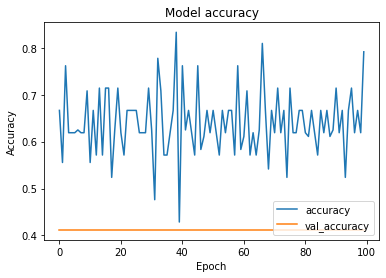

In [73]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

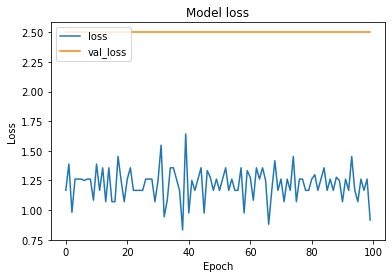

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [75]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

17/17 [==============================] - 1s 71ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [76]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['acne', 'papule']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        acne       0.00      0.00      0.00        10
      papule       0.41      1.00      0.58         7

    accuracy                           0.41        17
   macro avg       0.21      0.50      0.29        17
weighted avg       0.17      0.41      0.24        17



In [77]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

5/5 [==============================] - 0s 84ms/step


In [78]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

5/5 [==============================] - 0s 85ms/step


In [79]:
ground_truth=test['label']
print('Confusion Matrix')
print(confusion_matrix(ground_truth, y_pred))

Confusion Matrix
[[0 4]
 [0 1]]
